<a href="https://colab.research.google.com/github/fidocelli/Ear-tag-Project/blob/main/earTag_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Preprocessing

Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
file_path = '/content/drive/MyDrive/merged_data.csv'
data = pd.read_csv(file_path)

# Preprocessing
# Drop missing values
data = data.dropna()

# Convert datetime to pandas datetime
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data = data.dropna(subset=['datetime'])  # Drop rows with invalid datetime

# Sorting by ID and Time
data = data.sort_values(by='datetime').reset_index(drop=True)


<ipython-input-3-841ef2ff5d57>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
<ipython-input-3-841ef2ff5d57>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')


# Visual data analysis

Plotting histograms

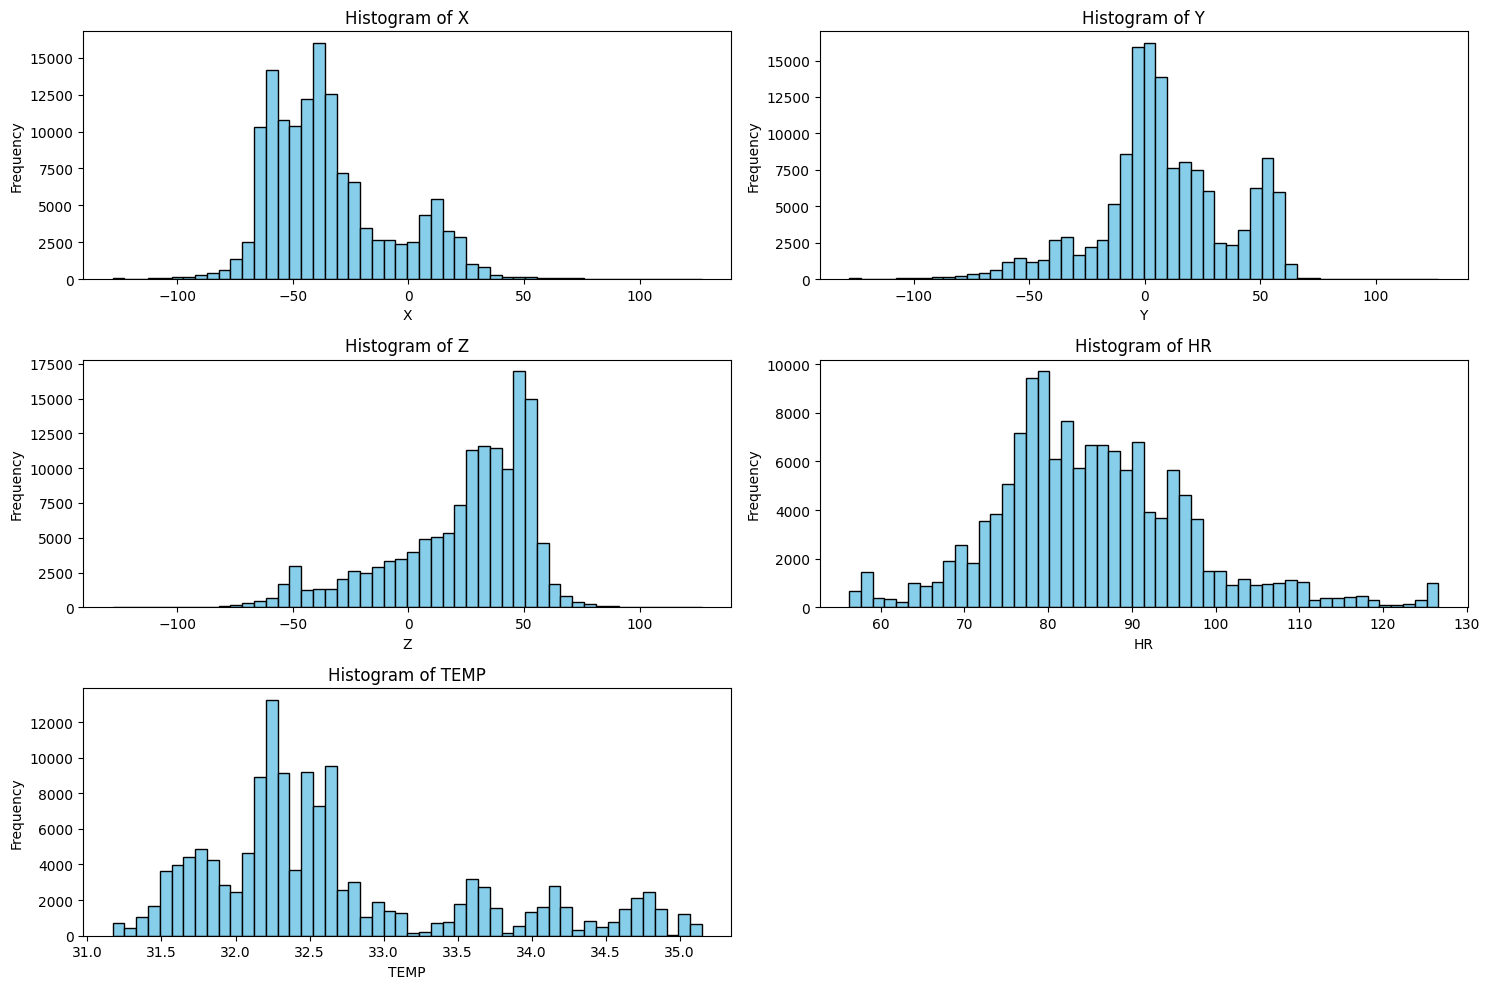

In [ ]:
# Plot Histograms
columns_to_plot = ['X', 'Y', 'Z', 'HR', 'TEMP']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(data[column], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Anomaly Detection and LSTM

Anomaly Detection

In [ ]:
# Anomaly Detection (Z-score method)
z_scores = data[columns_to_plot].apply(zscore)
anomalies = (z_scores.abs() > 3)  # Mark anomalies where |Z| > 3

# Add a column indicating anomalies
data['is_anomaly'] = anomalies.any(axis=1)

# Print the count of anomalies
print("Anomaly count per column:")
print(anomalies.sum())
print(f"Total rows with anomalies: {data['is_anomaly'].sum()}")


Anomaly count per column:
X        737
Y        698
Z        621
HR      1599
TEMP       0
dtype: int64
Total rows with anomalies: 3558


LSTM (Long-Term Short Memory) Analysis

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.0221
Epoch 2/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0163
Epoch 3/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0156
Epoch 4/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0154
Epoch 5/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0154
Epoch 6/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0152
Epoch 7/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0151
Epoch 8/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 0.0150
Epoch 9/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0149
Epoch 10/10
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0149
4320/4320 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
LSTM detected 6912 anomalies out of 138233 samples.


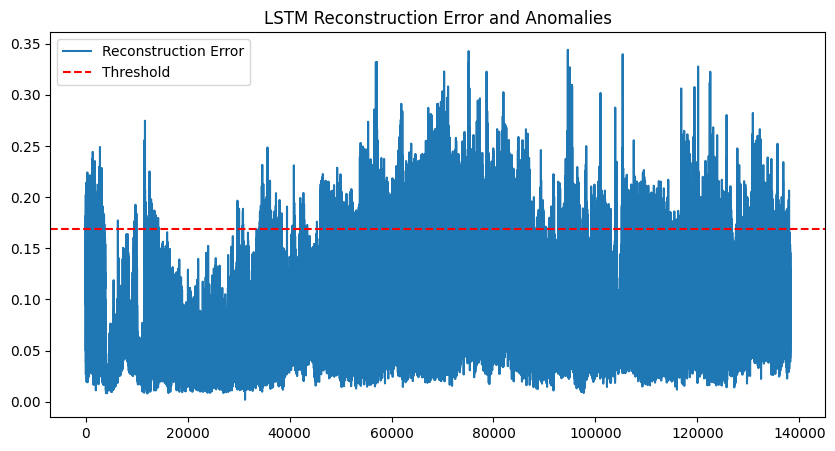

In [ ]:
#LSTM Analysis
# Prepare data for LSTM: Use only numerical features and normalize
features = ['X', 'Y', 'Z', 'HR', 'TEMP']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# Convert to a supervised learning problem
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])
X, y = np.array(X), np.array(y)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(features))),
    Dense(len(features))
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# Predict and evaluate reconstruction error
predictions = model.predict(X)
errors = np.mean(np.abs(predictions - y), axis=1)

# Threshold for anomaly detection
threshold = np.percentile(errors, 95)  # Set threshold as 95th percentile of errors
lstm_anomalies = errors > threshold

print(f"LSTM detected {lstm_anomalies.sum()} anomalies out of {len(errors)} samples.")

# Visualize the anomalies
plt.figure(figsize=(10, 5))
plt.plot(errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('LSTM Reconstruction Error and Anomalies')
plt.legend()
plt.show()


# Outlier detection in temperature and heart-rate

Temperature plot with anomaly detection

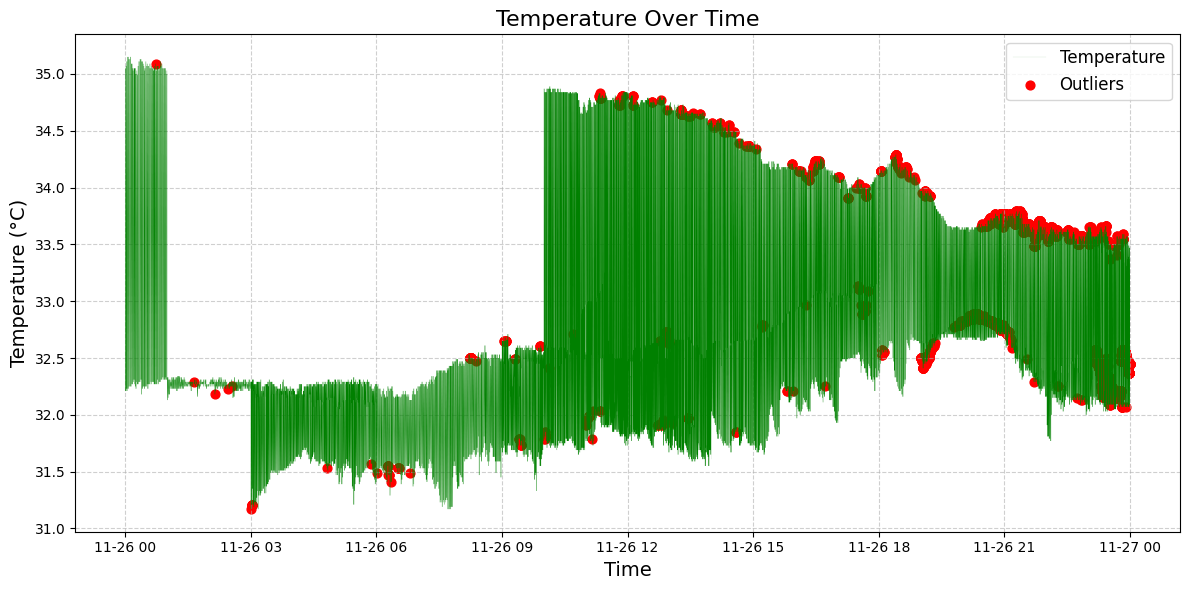

In [ ]:
import matplotlib.pyplot as plt

# Plot Temperature as a Line Graph
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['TEMP'], label='Temperature', color='green', linewidth=0.05, alpha=1)
plt.scatter(data[data['is_anomaly']]['datetime'], data[data['is_anomaly']]['TEMP'],
            color='red', label='Outliers', s=40)
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Heart rate plot with anomaly detection

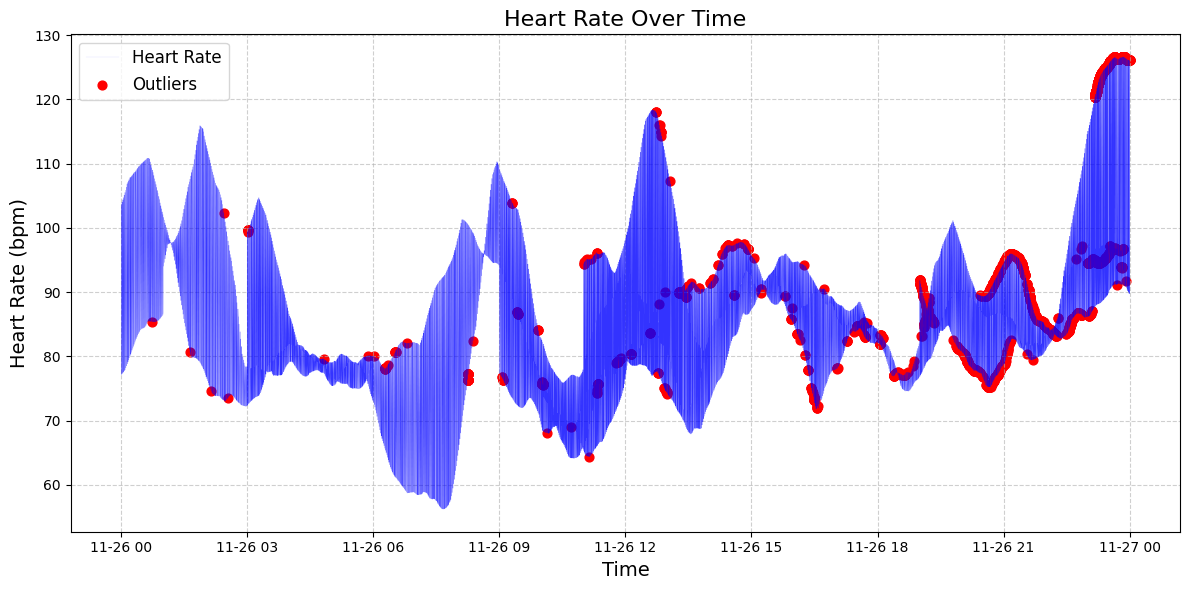

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'datetime' is in the correct format
data['datetime'] = pd.to_datetime(data['datetime'])

# Plot Heart Rate as a Line Graph
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['HR'], label='Heart Rate', color='blue', linewidth=.05, alpha=0.8)
plt.scatter(data[data['is_anomaly']]['datetime'], data[data['is_anomaly']]['HR'],
            color='red', label='Outliers', s=40)
plt.title('Heart Rate Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Heart Rate (bpm)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
